In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')

import glob
locations = glob.glob('/checkpoint/nolte/nuclr/long-runs/*')

keys = [l.split('/')[-1].split('-')[1] for l in locations]
def cleanup(name):
    if '+' in name: return 'all'
    while name[-1].isdigit() or name[-1] == '.':
        name = name[:-1]
    return name
keys = [cleanup(k) for k in keys]
locations = {key:l for key, l in zip(keys, locations)}
task_rms_values = {}


In [65]:
model_name = 'all'
location = locations[model_name]
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(f"{location}/ckpts/model-40000.pt", map_location=args.DEV))

<All keys matched successfully>

In [66]:
os.listdir(f"{location}/ckpts")

['model-80000.pt',
 'model.pt',
 'model-160000.pt',
 'model-40000.pt',
 'model-0.pt',
 'model-120000.pt']

In [67]:
def get_penultimate_acts(model, X):
    # Save the last layer activations
    acts = torch.zeros(len(X), args.HIDDEN_DIM, device=args.DEV)
    # save the activations fed into the readout layer
    hook = model.readout.register_forward_pre_hook(
        lambda m, i: print(m) or acts.copy_(i[0].detach())
    )
    model(X)
    hook.remove()
    return acts

X = data.X 
y = data.y.view(-1)
mask = (X[:, 2] == 0) & ~torch.isnan(y) & (X[:, 0] > 8) & (X[:, 1] > 8)
X, y = X[mask], y[mask]

acts = get_penultimate_acts(model, X)

MuReadout(in_features=2048, out_features=10, bias=True)


In [68]:
z_emb, n_emb = model.emb[0], model.emb[1]

In [69]:
pca = PCA(n_components=10)
emb_pca = pca.fit_transform(n_emb.detach().cpu().numpy())
print(pca.explained_variance_ratio_)

[0.21478021 0.01394005 0.01241363 0.01095342 0.01033422 0.00875953
 0.00816949 0.00788446 0.00723371 0.00710145]


In [86]:
def measure_parity_split(data, number):
    def distance(a, b):
        # Define your distance function here
        return np.linalg.norm(a - b)

    odd_position_distances = []
    consecutive_distances = []

    n_elements = len(number)

    for i in range(0, n_elements):
        if i+2 < n_elements:
            odd_position_distances.append(distance(data[i], data[i+2]))
        if i+1 < n_elements:
            consecutive_distances.append(distance(data[i], data[i+1]))

    avg_odd_position_distance = sum(odd_position_distances) / len(odd_position_distances)
    avg_consecutive_distance = sum(consecutive_distances) / len(consecutive_distances)

    return avg_consecutive_distance / avg_odd_position_distance
  

measure_parity_split(emb_pca[:, [0,1]], np.arange(len(emb_pca)))

3.6754361653791863

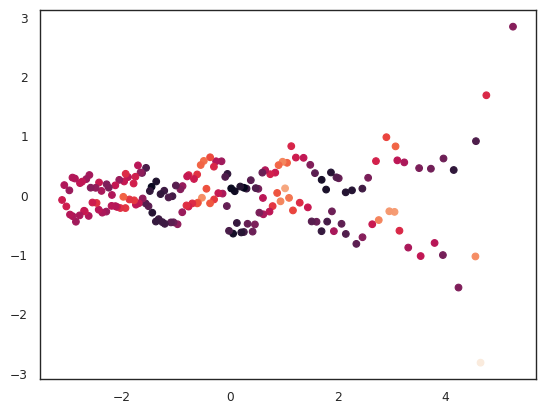

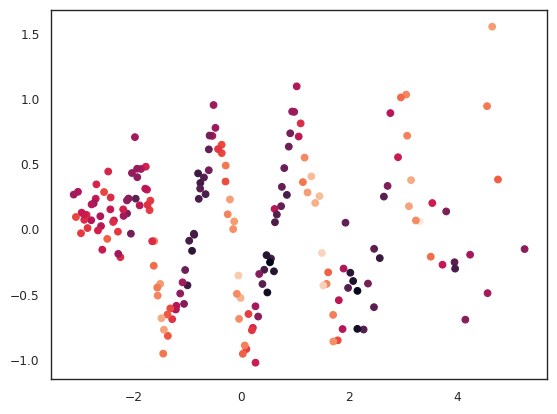

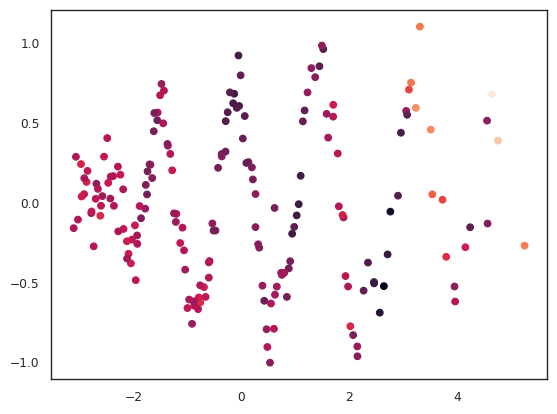

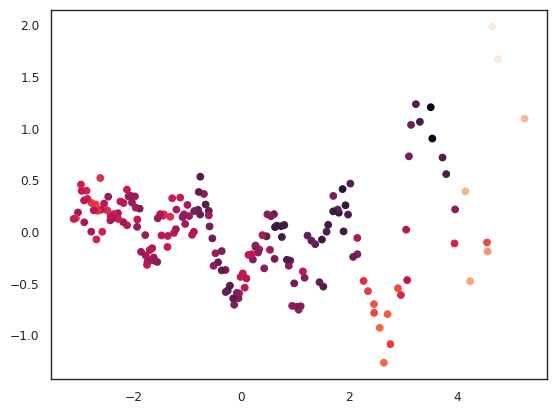

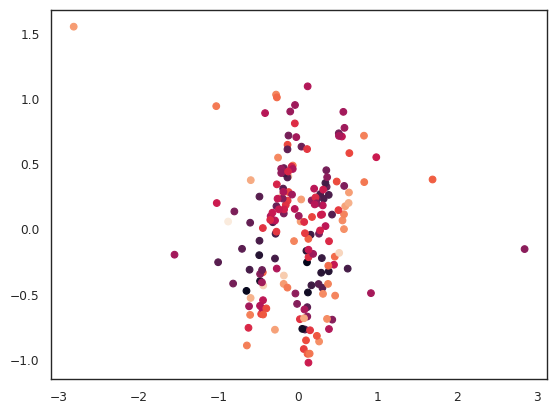

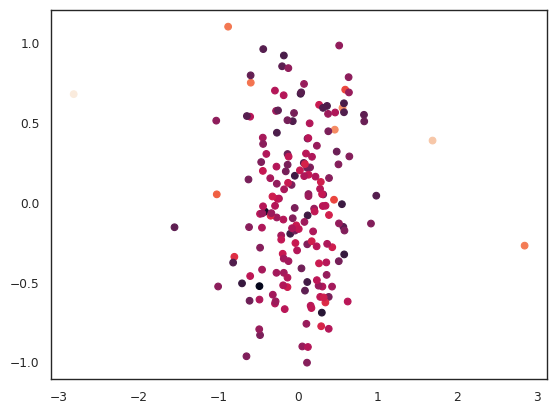

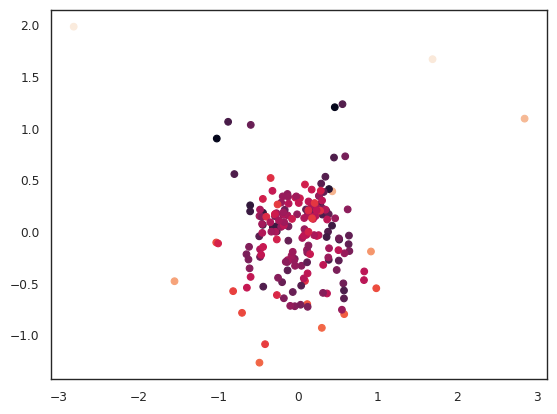

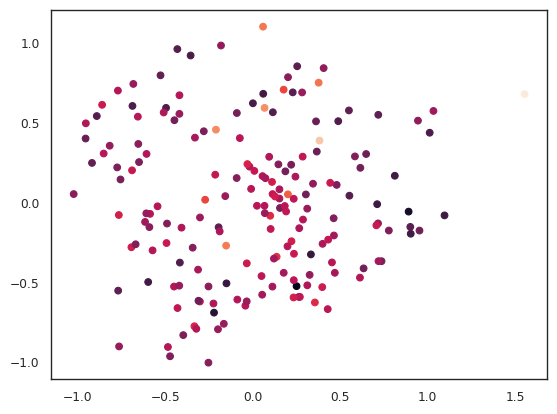

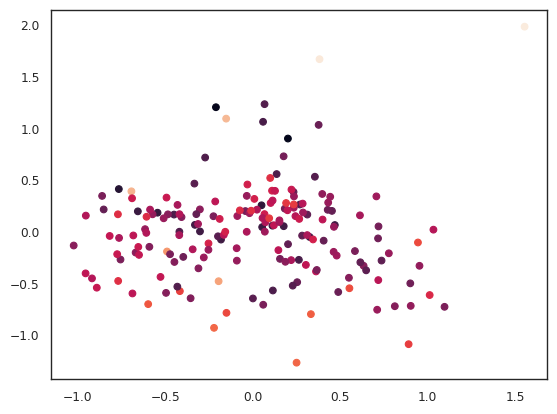

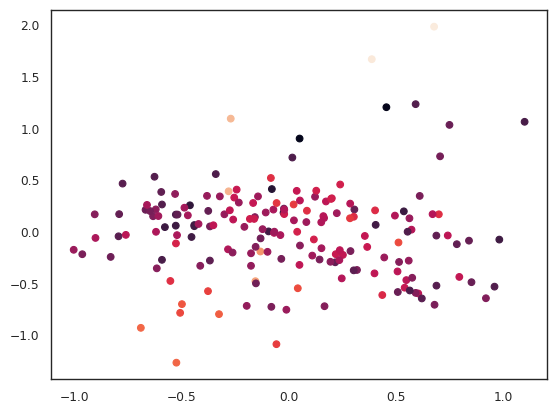

In [70]:
for first in range(5):
  for second in range(first+1, 5):
    plt.scatter(emb_pca[:, first], emb_pca[:, second], c=emb_pca[:,second+1])
    plt.show()

Epoch [100/3000], Loss: 2.6836
Epoch [200/3000], Loss: 2.0824
Epoch [300/3000], Loss: 1.0603
Epoch [400/3000], Loss: 0.6547
Epoch [500/3000], Loss: 0.2759
Epoch [600/3000], Loss: 0.2112
Epoch [700/3000], Loss: 0.1752
Epoch [800/3000], Loss: 0.1494
Epoch [900/3000], Loss: 0.1314
Epoch [1000/3000], Loss: 0.1194
Epoch [1100/3000], Loss: 0.1118
Epoch [1200/3000], Loss: 0.1072
Epoch [1300/3000], Loss: 0.1045
Epoch [1400/3000], Loss: 0.1030
Epoch [1500/3000], Loss: 0.1023
Epoch [1600/3000], Loss: 0.1019
Epoch [1700/3000], Loss: 0.1017
Epoch [1800/3000], Loss: 0.1016
Epoch [1900/3000], Loss: 0.1016
Epoch [2000/3000], Loss: 0.1016
Epoch [2100/3000], Loss: 0.1015
Epoch [2200/3000], Loss: 0.1015
Epoch [2300/3000], Loss: 0.1015
Epoch [2400/3000], Loss: 0.1015
Epoch [2500/3000], Loss: 0.1016
Epoch [2600/3000], Loss: 0.1015
Epoch [2700/3000], Loss: 0.1015
Epoch [2800/3000], Loss: 0.1015
Epoch [2900/3000], Loss: 0.1015
Epoch [3000/3000], Loss: 0.1015


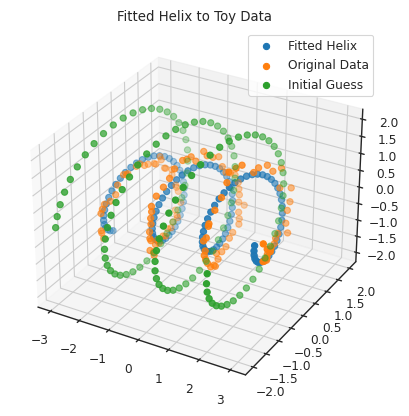

In [74]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch

def find_orthonormal_basis(a):
    """
    Find two orthonormal vectors that are perpendicular to the vector a in PyTorch.
    """
    if a[0] != 0 or a[1] != 0:
        v1 = torch.tensor([-a[1], a[0], 0], dtype=torch.float32)
    else:
        v1 = torch.tensor([0, -a[2], a[1]], dtype=torch.float32)
    v1 = v1 / torch.norm(v1)
    v2 = torch.cross(a, v1)
    return v1, v2

def helix(t, R, F, P, axis, start, phase):
    """
    Parametric equations for a 3D spiral (helix) around a specified axis in PyTorch.
    """
    # Normalize the axis
    a = axis / torch.norm(axis)
    
    # Find two orthonormal vectors perpendicular to the axis
    u, v = find_orthonormal_basis(a)

    # Circular motion around the axis
    V_perp = R * (torch.cos(2*torch.pi * F * t + phase)[:, None] * u + torch.sin(2*torch.pi*F * t + phase)[:, None] * v)

    # Movement along the axis
    V_axis = P * t[:, None] * a

    return V_perp + V_axis + start

# Parameters as PyTorch tensors
t = torch.linspace(0, 1, len(emb_pca), requires_grad=False)
R = torch.tensor(2.0, requires_grad=True)  # Radius
F = torch.tensor(-3., requires_grad=True)  # Frequency
P = torch.tensor(5., requires_grad=True)  # Pitch
axis = torch.tensor([1.,0.,0.], requires_grad=True, dtype=torch.float32)  # Axis of the spiral
start = torch.tensor([-3.,0.,0.], requires_grad=True, dtype=torch.float32)  # Start point of the spiral
phase = torch.tensor(3.14, requires_grad=True)  # Phase shift of the spiral

with torch.no_grad():
  initial_guess = helix(t, R, F, P, axis, start, phase)

# Toy data generation
# t = torch.linspace(0, 5, len(emb_pca))
# R_true = 1
# F_true = 0.3 * 2 * torch.pi
# P_true = 4
# axis_true = torch.tensor([1., 0., 1.], dtype=torch.float32)  # Arbitrary axis
# start_point = torch.tensor([0., 0., 0.], dtype=torch.float32)  # Arbitrary start point

# Generating the helix data
# data = helix(t, R_true, F_true, P_true, axis_true, start_point)
data_spiral = torch.tensor(emb_pca[:,:3], requires_grad=False)

# # Optimizer
optimizer = optim.Adam([R, F, P, axis, start], lr=0.01)

# Loss function
def loss_fn(predicted, target):
    return ((predicted - target)**2).mean()

# Training loop
epochs = 3000
for epoch in range(epochs):
    optimizer.zero_grad()
    predicted = helix(t, R, F, P, axis, start, phase)
    loss = loss_fn(predicted, data_spiral)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plotting the results
predicted = helix(t, R, F, P, axis, start, phase).detach().numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(predicted[:, 0], predicted[:, 1], predicted[:, 2], label='Fitted Helix')
ax.scatter(data_spiral[:, 0], data_spiral[:, 1], data_spiral[:, 2], label='Original Data')
ax.scatter(initial_guess[:, 0], initial_guess[:, 1], initial_guess[:, 2], label='Initial Guess')
# plot the vectors
plt.title('Fitted Helix to Toy Data')
plt.legend()
plt.show()



In [75]:
def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return tensor * (max_ - min_) + min_

def get_preds_from_acts(acts):
    pred = model.readout(acts)
    pred = inverse_transform(pred, data)
    return pred[:, 0]

def get_preds(model, data, X):
  with torch.inference_mode():
    out = model(X)
    pred = inverse_transform(out, data)
    return pred[:,0]

In [76]:
spiral_embs = emb_pca.copy()
spiral_embs[:, :3] = predicted
spiral_embs = pca.inverse_transform(spiral_embs)
spiral_embs = torch.tensor(spiral_embs, device=args.DEV).float()
spiral_embs

tensor([[ 0.0392,  0.1082,  0.0407,  ..., -0.0283, -0.1390, -0.0978],
        [ 0.0509,  0.0970,  0.0410,  ..., -0.0242, -0.1129, -0.0836],
        [ 0.0603,  0.0765,  0.0446,  ..., -0.0291, -0.0856, -0.0850],
        ...,
        [-0.0817, -0.0733, -0.0636,  ...,  0.0683,  0.0833,  0.0957],
        [-0.0863, -0.0707, -0.0599,  ...,  0.0709,  0.0778,  0.0967],
        [-0.0807, -0.0740, -0.0590,  ...,  0.0703,  0.0976,  0.1306]])

In [77]:
from copy import deepcopy
with torch.no_grad():
  model_spiral = deepcopy(model)
  model_spiral.emb[1][20:140] = spiral_embs
  model_spiral.readout = model.readout

In [78]:
preds_spiral = get_preds(model_spiral, data, X)
preds = get_preds(model, data, X)

In [79]:
(preds - y).square().mean().sqrt(), (preds_spiral - y).square().mean().sqrt()

(tensor(221.1105, dtype=torch.float64),
 tensor(13767.2299, dtype=torch.float64))